# Expected Improvement BO


In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Import the class
import torch
import yaml

## Customizing the UpperConfidenceBound Generator
First lets examine the possible options that we can specify for the
UpperConfidenceBound generator. We can use these keys to customize optimization.

In [2]:
from xopt.generators import get_generator_and_defaults
ei_gen, ei_options = get_generator_and_defaults("expected_improvement")
print(yaml.dump(ei_options.dict()))

acq:
  monte_carlo_samples: 128
  proximal_lengthscales: null
  use_transformed_proximal_weights: true
model:
  function: !!python/name:xopt.generators.bayesian.models.standard.create_standard_model ''
  kwargs:
    use_conservative_prior_lengthscale: false
    use_conservative_prior_mean: false
    use_low_noise_prior: false
n_initial: 3
optim:
  max_travel_distances: null
  num_restarts: 5
  raw_samples: 20
  sequential: true
  use_nearby_initial_points: false
use_cuda: false



In [3]:
from xopt.resources.test_functions.rosenbrock import make_rosenbrock_vocs, evaluate_rosenbrock
from xopt import Xopt, Evaluator
import pandas as pd

vocs = make_rosenbrock_vocs(2)

generator_options = ei_gen.default_options()
generator_options.optim.num_restarts = 20
generator_options.optim.max_travel_distances = [0.1, 0.1]
generator_options.model.kwargs.use_low_noise_prior = True
#generator_options.acq.proximal_lengthscales = [0.01, 0.01]

evaluator = Evaluator(function=evaluate_rosenbrock)
generator = ei_gen(vocs, generator_options)


In [4]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

for i in range(100):
    X.step()
    print(f"step {i}: best: {X.data['y'].min()}")


step 0: best: 183.77015200169768
step 1: best: 183.77015200169768
step 2: best: 183.77015200169768
step 3: best: 183.77015200169768
step 4: best: 183.77015200169768
step 5: best: 183.77015200169768
step 6: best: 183.77015200169768
step 7: best: 182.2026905020396
step 8: best: 104.26504963185157
step 9: best: 90.26136615095137
step 10: best: 36.423313658156744
step 11: best: 36.423313658156744
step 12: best: 14.63335969485318
step 13: best: 8.679351830804665
step 14: best: 8.679351830804665
step 15: best: 8.679351830804665
step 16: best: 2.176169424924846
step 17: best: 2.176169424924846
step 18: best: 2.176169424924846
step 19: best: 2.176169424924846
step 20: best: 2.176169424924846
step 21: best: 2.176169424924846
step 22: best: 2.176169424924846
step 23: best: 2.176169424924846
step 24: best: 2.176169424924846
step 25: best: 2.176169424924846
step 26: best: 2.176169424924846
step 27: best: 2.176169424924846
step 28: best: 2.176169424924846
step 29: best: 2.176169424924846
step 30: b

## View output data

In [5]:
X.data

,x0,x1,y,xopt_runtime,xopt_error
1,-0.039636,-1.387263,193.966713,0.000015,False
2,-1.992282,-0.234896,1776.387417,0.000005,False
3,-0.551061,1.650384,183.770152,0.000004,False
4,-0.367782,1.959860,334.786142,0.000015,False
5,-0.426577,1.829806,273.572229,0.000015,False
...,...,...,...,...,...
98,0.458917,-0.355037,32.287824,0.000014,False
99,0.206677,-0.434599,23.412255,0.000015,False
100,0.383705,-0.802675,90.611602,0.000014,False
101,0.253812,-1.110029,138.489947,0.000014,False


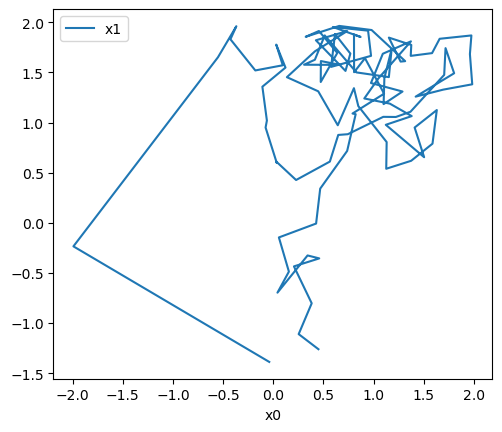

In [6]:
# plot results
ax = X.data.plot(*vocs.variable_names)
ax.set_aspect("equal")

## Visualize model used by upper confidence bound
Models are kept in a list, in this case that list has one element, the model
created for the objective `y1`.


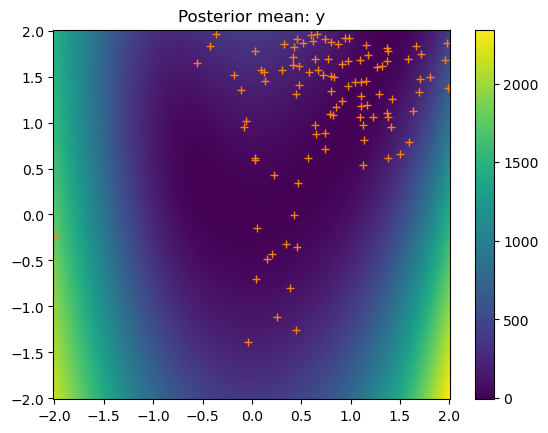

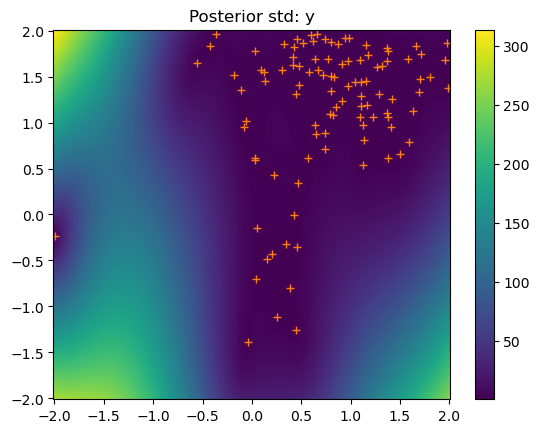

In [7]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.train_model(generator.data)

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    fig, ax = plt.subplots()
    ax.plot(*data[vocs.variable_names].to_numpy().T, "+C1")
    c = ax.pcolor(xx, yy, mean.reshape(n, n))
    fig.colorbar(c)
    ax.set_title(f"Posterior mean: {outputs[0]}")

    fig2, ax2 = plt.subplots()
    ax2.plot(*data[vocs.variable_names].to_numpy().T, "+C1")
    c = ax2.pcolor(xx, yy, std.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title(f"Posterior std: {outputs[0]}")

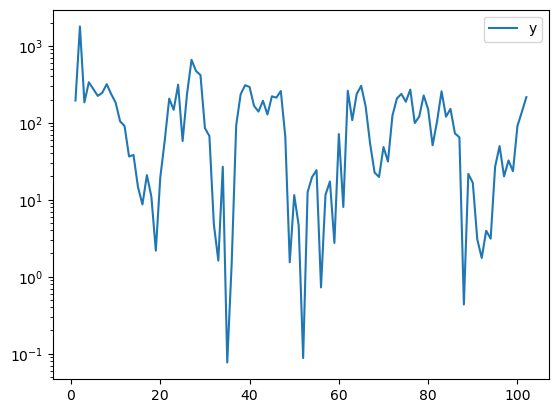

In [8]:
ax = X.data.plot(y="y", logy=True)

In [9]:
# Cleanup
!rm dump.yaml

rm: cannot remove 'dump.yaml': No such file or directory
